In [1]:
import pandas as pd
import os

In [5]:
data = pd.read_csv('dataset/faces/train.csv')

In [6]:
data.shape

(19906, 2)

In [7]:
import torch

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
device

'cpu'

In [10]:
data.shape

(19906, 2)

In [11]:
data.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [12]:
print(data['Class'].value_counts())

Class
MIDDLE    10804
YOUNG      6706
OLD        2396
Name: count, dtype: int64


In [13]:
class_map = {'YOUNG': 0, 'MIDDLE': 1, 'OLD': 2}
data['label'] = data['Class'].map(class_map)


In [30]:
dir = ("dataset/faces/Train/")

data['path'] = data['ID'].apply(lambda x: os.path.join(dir, str(x)))

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
display(data.head())

,ID,Class,label,path
0,377.jpg,MIDDLE,1,dataset/faces/Train/377.jpg
1,17814.jpg,YOUNG,0,dataset/faces/Train/17814.jpg
2,21283.jpg,MIDDLE,1,dataset/faces/Train/21283.jpg
3,16496.jpg,YOUNG,0,dataset/faces/Train/16496.jpg
4,4487.jpg,MIDDLE,1,dataset/faces/Train/4487.jpg


In [31]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

YOUNG


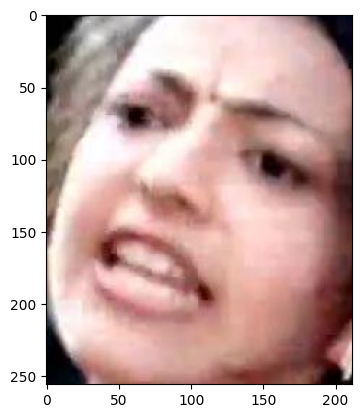

MIDDLE


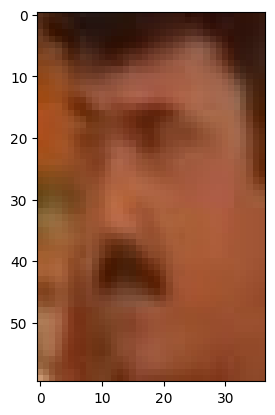

MIDDLE


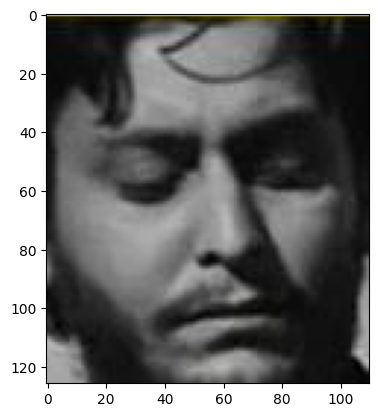

YOUNG


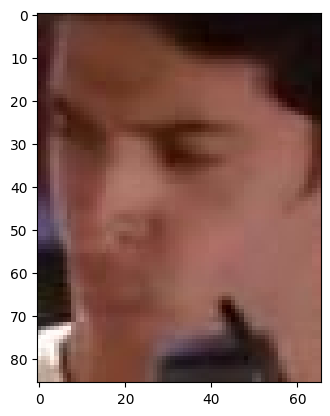

MIDDLE


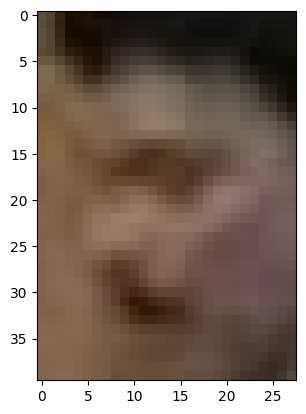

In [32]:
for i in range(5):
    r =np.random.randint(0,1800)
    img = Image.open(data.loc[r, 'path'])
    print(data.loc[r, 'Class'])
    plt.imshow(img)
    plt.show()

In [33]:
path_label = list(zip(data['path'], data['label']))

In [34]:
path_label[:10]

[('dataset/faces/Train/377.jpg', 1),
 ('dataset/faces/Train/17814.jpg', 0),
 ('dataset/faces/Train/21283.jpg', 1),
 ('dataset/faces/Train/16496.jpg', 0),
 ('dataset/faces/Train/4487.jpg', 1),
 ('dataset/faces/Train/6283.jpg', 1),
 ('dataset/faces/Train/23495.jpg', 0),
 ('dataset/faces/Train/7100.jpg', 0),
 ('dataset/faces/Train/6028.jpg', 0),
 ('dataset/faces/Train/22617.jpg', 2)]

In [35]:
import torchvision.transforms as transforms

In [36]:
transform = transforms.Compose([transforms.Resize(96), transforms.CenterCrop(96), 
                                transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [37]:
from torch.utils.data import Dataset,DataLoader
import torch

In [38]:
class SimpleImageDataset(Dataset):
    def __init__(self, path_label, transform=None):
        self.path_label = path_label
        self.transform = transform

    def __len__(self):
        return len(self.path_label)

    def __getitem__(self, idx):
        path, label = self.path_label[idx]
        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


img_dataset = SimpleImageDataset(path_label, transform)

In [39]:
img_dataset[0][0].shape

torch.Size([3, 96, 96])

In [40]:

image_size=len(img_dataset)

train_size=int(0.8*image_size)


test_size=image_size-train_size

from torch.utils.data import random_split

train, test = random_split(img_dataset, [train_size, test_size])

print(f'Actual training size is {len(train)}')
print(f'Actual testing size is {len(test)}')

Actual training size is 15924
Actual testing size is 3982


In [41]:
train_loader = DataLoader(train,batch_size=32,shuffle=True)
test_loader = DataLoader(test,batch_size=32,shuffle=True)

In [42]:
import torch.nn as nn
import torch.nn.functional as F

In [43]:
class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128*12*12, 120) 
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [48]:
checkpoint = torch.load('checkpoint.pth',map_location=torch.device('cpu'))
pre_t_model = checkpoint['model']
pre_t_model.load_state_dict(checkpoint['state_dict'])
for parameter in pre_t_model.parameters():
        parameter.requires_grad = False
pre_t_model.eval()

ConvNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=18432, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=3, bias=True)
)

In [50]:
c = 0
t = 0
with torch.no_grad():
    for images,labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        pred =pre_t_model(images)
        _, predicted = torch.max(pred.data, 1)
        c += (predicted==labels).sum().item()
        t+=labels.size(0)
print("Total:",t)
print("Correctly predicted:",c)
print(c/t*100,"%")

Total: 3982
Correctly predicted: 3727
93.59618282270216 %


In [35]:
model = ConvNN()
model.to(device)

ConvNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=18432, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=3, bias=True)
)

In [36]:
print(model)

ConvNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=18432, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=3, bias=True)
)


In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [39]:
num_epoches = 25
model.train()
for epoch in range(num_epoches):
    for idx,(images,labels) in enumerate(train_loader):
        images,labels = images.to(device),labels.to(device)
        
        pred = model(images)
        
        loss = criterion(pred,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch:",(epoch+1),"/",num_epoches,"Loss:",loss.item()) 

Epoch: 1 / 25 Loss: 0.5501598119735718
Epoch: 2 / 25 Loss: 0.8921180963516235
Epoch: 3 / 25 Loss: 0.43250027298927307
Epoch: 4 / 25 Loss: 0.6635016202926636
Epoch: 5 / 25 Loss: 0.5099108219146729
Epoch: 6 / 25 Loss: 0.2127373218536377
Epoch: 7 / 25 Loss: 0.17130455374717712
Epoch: 8 / 25 Loss: 0.08727617561817169
Epoch: 9 / 25 Loss: 0.17458589375019073
Epoch: 10 / 25 Loss: 0.05002923682332039
Epoch: 11 / 25 Loss: 0.13598039746284485
Epoch: 12 / 25 Loss: 0.004503671079874039
Epoch: 13 / 25 Loss: 0.04999055713415146
Epoch: 14 / 25 Loss: 0.04120416194200516
Epoch: 15 / 25 Loss: 0.01761755719780922
Epoch: 16 / 25 Loss: 0.13452859222888947
Epoch: 17 / 25 Loss: 0.005533143412321806
Epoch: 18 / 25 Loss: 0.3641236424446106
Epoch: 19 / 25 Loss: 0.00035605503944680095
Epoch: 20 / 25 Loss: 0.0015320194652304053
Epoch: 21 / 25 Loss: 0.00455009238794446
Epoch: 22 / 25 Loss: 0.0053679379634559155
Epoch: 23 / 25 Loss: 0.01724422350525856
Epoch: 24 / 25 Loss: 0.050731461495161057
Epoch: 25 / 25 Loss: 

In [42]:
model.eval()
c = 0
t = 0
with torch.no_grad():
    for images,labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        pred = model(images)
        _, predicted = torch.max(pred.data, 1)
        c += (predicted==labels).sum().item()
        t+=labels.size(0)
print("Total:",t)
print("Correctly predicted:",c)
print(c/t*100,"%")

Total: 3982
Correctly predicted: 2940
73.83224510296333 %


In [43]:

print("The state dict keys: \n\n", model.state_dict().keys())


The state dict keys: 

 odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])


In [44]:
checkpoint = {'model': ConvNN(),
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

In [45]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    model.eval()
    
    return model

In [46]:
Nmodel = load_checkpoint('checkpoint.pth')
print(Nmodel)

ConvNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=18432, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=3, bias=True)
)


In [47]:
Nmodel.to(device)
c = 0
t = 0
with torch.no_grad():
    for images,labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        pred = Nmodel(images)
        _, predicted = torch.max(pred.data, 1)
        c += (predicted==labels).sum().item()
        t+=labels.size(0)
print("Total:",t)
print("Correctly predicted:",c)
print(c/t*100,"%")

Total: 3982
Correctly predicted: 2940
73.83224510296333 %
